<a href="https://colab.research.google.com/github/crux007/crux007/blob/main/ClickFraud_detection_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [34]:
!pip install tensorflow

In [122]:
!pip install pillow flask

In [119]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.neighbors import LocalOutlierFactor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, homogeneity_score, adjusted_rand_score, completeness_score
from sklearn.ensemble import VotingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.utils import plot_model
from sklearn.ensemble import VotingClassifier
from tensorflow.keras.layers import Dense
import pickle
from flask import Flask, request
from PIL import Image, ImageDraw, ImageFont
import random
import string

In [18]:
data = pd.read_csv('/content/drive/MyDrive/cr_new_cleaned.csv')

In [19]:
random_seed = 42

In [20]:
# Randomly select 10,000 rows from the DataFrame
df = data.sample(n=50000, random_state=random_seed)

In [21]:
selected_features = ['sc-status', 'cs-method', 'c-country', 'day_of_week', 'hour', 'minute', 'second', 'c-ip-int', 'browser_family', 'browser_version']
new_df = df[selected_features].dropna()

In [22]:
for feature in selected_features:
    new_df[feature] = new_df[feature].astype(int)

In [23]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(new_df)

In [24]:
lof = LocalOutlierFactor(n_neighbors=20, contamination='auto')
outlier_scores = lof.fit_predict(X_scaled)

In [25]:
bot_users = X_scaled[outlier_scores == -1]
non_bot_users = X_scaled[outlier_scores == 1]

In [26]:
# Add labels to the original dataframe
df['label'] = 0
df.loc[outlier_scores == -1, 'label'] = 1

In [27]:
lof_silhouette = silhouette_score(X_scaled, -outlier_scores)
lof_homogeneity = homogeneity_score(df['label'], -outlier_scores)
lof_completeness = completeness_score(df['label'], -outlier_scores)
lof_ari = adjusted_rand_score(df['label'], -outlier_scores)

In [28]:
print("\nLOF Metrics:")
print("Silhouette Score:", lof_silhouette)
print("Homogeneity Score:", lof_homogeneity)
print("Completeness Score:", lof_completeness)
print("Adjusted Rand Index (ARI):", lof_ari)


LOF Metrics:
Silhouette Score: 0.6489590305337154
Homogeneity Score: 1.0
Completeness Score: 1.0
Adjusted Rand Index (ARI): 1.0


In [29]:
n_clusters = 2
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
kmeans.fit(X_scaled)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


KMeans(n_clusters=2, random_state=42)

In [30]:
kmeans_silhouette = silhouette_score(X_scaled, kmeans.labels_)
kmeans_homogeneity = homogeneity_score(df['label'], kmeans.labels_)
kmeans_completeness = completeness_score(df['label'], kmeans.labels_)
kmeans_ari = adjusted_rand_score(df['label'], kmeans.labels_)

In [31]:
print("K-means Clustering Metrics:")
print("Silhouette Score:", kmeans_silhouette)
print("Homogeneity Score:", kmeans_homogeneity)
print("Completeness Score:", kmeans_completeness)
print("Adjusted Rand Index (ARI):", kmeans_ari)

K-means Clustering Metrics:
Silhouette Score: 0.2512430276262663
Homogeneity Score: 0.05434759666034824
Completeness Score: 0.0012075309424798852
Adjusted Rand Index (ARI): 0.00515630477141781


In [32]:
print("Number of bot users:", bot_users.shape[0])
print("Number of non-bot users:", non_bot_users.shape[0])
print("Percentage of bot users:", bot_users.shape[0] / X_scaled.shape[0])

Number of bot users: 63
Number of non-bot users: 49937
Percentage of bot users: 0.00126


In [41]:
def build_kmeans_ensemble(data, n_clusters, n_models):
    kmeans_ensemble = []
    for _ in range(n_models):
        kmeans = KMeans(n_clusters=n_clusters, random_state=42)
        kmeans.fit(X_scaled)
        kmeans_ensemble.append(kmeans)
    return kmeans_ensemble

In [42]:
def build_lof_ensemble(data, n_neighbors, n_models):
    lof_ensemble = []
    for _ in range(n_models):
        lof = LocalOutlierFactor(n_neighbors=n_neighbors, contamination='auto')
        outlier_scores = lof.fit_predict(X_scaled)
        lof_ensemble.append(lof)
    return lof_ensemble

In [43]:
def ensemble_predict(kmeans_ensemble, lof_ensemble, data):
    kmeans_predictions = [model.predict(X_scaled) for model in kmeans_ensemble]
    lof_predictions = [model.fit_predict(X_scaled) for model in lof_ensemble]

    ensemble_predictions = []
    for i in range(len(X_scaled)):
        kmeans_votes = sum([prediction[i] for prediction in kmeans_predictions])
        lof_votes = sum([prediction[i] for prediction in lof_predictions])
        if kmeans_votes >= len(kmeans_predictions) / 2 and lof_votes <= len(lof_predictions) / 2:
            ensemble_predictions.append(1)  # Bot user
        else:
            ensemble_predictions.append(0)  # Non-bot user
    return ensemble_predictions

In [44]:
n_models = 5
n_neighbors = 20
n_clusters = 2

In [45]:
kmeans_ensemble = build_kmeans_ensemble(X_scaled, n_clusters, n_models)
lof_ensemble = build_lof_ensemble(X_scaled, n_neighbors, n_models)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

In [46]:
ensemble_predictions = ensemble_predict(kmeans_ensemble, lof_ensemble, X_scaled)

In [52]:
true_labels = df['label']
accuracy = accuracy_score(true_labels, ensemble_predictions)
precision = precision_score(true_labels, ensemble_predictions)
recall = recall_score(true_labels, ensemble_predictions)
f1 = f1_score(true_labels, ensemble_predictions)

In [53]:
print("Ensemble Performance:")
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)

Ensemble Performance:
Accuracy: 0.99944
Precision: 1.0
Recall: 0.5555555555555556
F1-score: 0.7142857142857143


In [59]:
new_df['ensemble_prediction'] = ensemble_predictions

In [60]:
new_df.head(50)

,sc-status,cs-method,c-country,day_of_week,hour,minute,second,c-ip-int,browser_family,browser_version,ensemble_prediction
137177,307,1,1,5,10,45,47,1378306861,3,19,0
114076,302,1,1,5,20,52,10,2548264967,11,243,0
246579,302,1,1,4,14,15,56,41477194,5,108,0
89629,302,1,1,7,15,32,17,1442834600,9,108,0
291153,307,1,1,3,20,9,56,2462550825,4,107,0
15594,307,1,1,5,23,11,28,1452361038,1,15,0
137485,307,1,1,2,11,40,32,1838326403,18,106,0
295192,307,1,1,7,16,33,41,1522617698,2,108,0
227649,302,1,1,3,22,33,15,526255645,3,19,0
160219,307,1,1,5,15,2,41,1367612370,7,0,0


import numpy as np
from google.colab import autoviz

def value_plot(df, y, figscale=1):
  from matplotlib import pyplot as plt
  df[y].plot(kind='line', figsize=(8 * figscale, 4 * figscale), title=y)
  plt.gca().spines[['top', 'right']].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = value_plot(_df_18, *['sc-status'], **{})
chart

import numpy as np
from google.colab import autoviz

def value_plot(df, y, figscale=1):
  from matplotlib import pyplot as plt
  df[y].plot(kind='line', figsize=(8 * figscale, 4 * figscale), title=y)
  plt.gca().spines[['top', 'right']].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = value_plot(_df_19, *['day_of_week'], **{})
chart

import numpy as np
from google.colab import autoviz

def value_plot(df, y, figscale=1):
  from matplotlib import pyplot as plt
  df[y].plot(kind='line', figsize=(8 * figscale, 4 * figscale), title=y)
  plt.gca().spines[['top', 'right']].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = value_plot(_df_20, *['hour'], **{})
chart

import numpy as np
from google.colab import autoviz

def value_plot(df, y, figscale=1):
  from matplotlib import pyplot as plt
  df[y].plot(kind='line', figsize=(8 * figscale, 4 * figscale), title=y)
  plt.gca().spines[['top', 'right']].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = value_plot(_df_21, *['minute'], **{})
chart

import numpy as np
from google.colab import autoviz

def histogram(df, colname, num_bins=20, figscale=1):
  from matplotlib import pyplot as plt
  df[colname].plot(kind='hist', bins=num_bins, title=colname, figsize=(8*figscale, 4*figscale))
  plt.gca().spines[['top', 'right',]].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = histogram(_df_22, *['sc-status'], **{})
chart

import numpy as np
from google.colab import autoviz

def histogram(df, colname, num_bins=20, figscale=1):
  from matplotlib import pyplot as plt
  df[colname].plot(kind='hist', bins=num_bins, title=colname, figsize=(8*figscale, 4*figscale))
  plt.gca().spines[['top', 'right',]].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = histogram(_df_23, *['day_of_week'], **{})
chart

import numpy as np
from google.colab import autoviz

def histogram(df, colname, num_bins=20, figscale=1):
  from matplotlib import pyplot as plt
  df[colname].plot(kind='hist', bins=num_bins, title=colname, figsize=(8*figscale, 4*figscale))
  plt.gca().spines[['top', 'right',]].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = histogram(_df_24, *['hour'], **{})
chart

import numpy as np
from google.colab import autoviz

def histogram(df, colname, num_bins=20, figscale=1):
  from matplotlib import pyplot as plt
  df[colname].plot(kind='hist', bins=num_bins, title=colname, figsize=(8*figscale, 4*figscale))
  plt.gca().spines[['top', 'right',]].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = histogram(_df_25, *['minute'], **{})
chart

import numpy as np
from google.colab import autoviz

def scatter_plots(df, colname_pairs, figscale=1, alpha=.8):
  from matplotlib import pyplot as plt
  plt.figure(figsize=(len(colname_pairs) * 6 * figscale, 6 * figscale))
  for plot_i, (x_colname, y_colname) in enumerate(colname_pairs, start=1):
    ax = plt.subplot(1, len(colname_pairs), plot_i)
    df.plot(kind='scatter', x=x_colname, y=y_colname, s=(32 * figscale), alpha=alpha, ax=ax)
    ax.spines[['top', 'right',]].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = scatter_plots(_df_26, *[[['sc-status', 'day_of_week'], ['day_of_week', 'hour'], ['hour', 'minute'], ['minute', 'second']]], **{})
chart

import numpy as np
from google.colab import autoviz

def time_series_multiline(df, timelike_colname, value_colname, series_colname, figscale=1, mpl_palette_name='Dark2'):
  from matplotlib import pyplot as plt
  import seaborn as sns
  figsize = (10 * figscale, 5.2 * figscale)
  palette = list(sns.palettes.mpl_palette(mpl_palette_name))
  def _plot_series(series, series_name, series_index=0):
    if value_colname == 'count()':
      counted = (series[timelike_colname]
                 .value_counts()
                 .reset_index(name='counts')
                 .rename({'index': timelike_colname}, axis=1)
                 .sort_values(timelike_colname, ascending=True))
      xs = counted[timelike_colname]
      ys = counted['counts']
    else:
      xs = series[timelike_colname]
      ys = series[value_colname]
    plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

  fig, ax = plt.subplots(figsize=figsize, layout='constrained')
  df = df.sort_values(timelike_colname, ascending=True)
  if series_colname:
    for i, (series_name, series) in enumerate(df.groupby(series_colname)):
      _plot_series(series, series_name, i)
    fig.legend(title=series_colname, bbox_to_anchor=(1, 1), loc='upper left')
  else:
    _plot_series(df, '')
  sns.despine(fig=fig, ax=ax)
  plt.xlabel(timelike_colname)
  plt.ylabel(value_colname)
  return autoviz.MplChart.from_current_mpl_state()

chart = time_series_multiline(_df_27, *['cs-method', 'sc-status', None], **{})
chart

import numpy as np
from google.colab import autoviz

def time_series_multiline(df, timelike_colname, value_colname, series_colname, figscale=1, mpl_palette_name='Dark2'):
  from matplotlib import pyplot as plt
  import seaborn as sns
  figsize = (10 * figscale, 5.2 * figscale)
  palette = list(sns.palettes.mpl_palette(mpl_palette_name))
  def _plot_series(series, series_name, series_index=0):
    if value_colname == 'count()':
      counted = (series[timelike_colname]
                 .value_counts()
                 .reset_index(name='counts')
                 .rename({'index': timelike_colname}, axis=1)
                 .sort_values(timelike_colname, ascending=True))
      xs = counted[timelike_colname]
      ys = counted['counts']
    else:
      xs = series[timelike_colname]
      ys = series[value_colname]
    plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

  fig, ax = plt.subplots(figsize=figsize, layout='constrained')
  df = df.sort_values(timelike_colname, ascending=True)
  if series_colname:
    for i, (series_name, series) in enumerate(df.groupby(series_colname)):
      _plot_series(series, series_name, i)
    fig.legend(title=series_colname, bbox_to_anchor=(1, 1), loc='upper left')
  else:
    _plot_series(df, '')
  sns.despine(fig=fig, ax=ax)
  plt.xlabel(timelike_colname)
  plt.ylabel(value_colname)
  return autoviz.MplChart.from_current_mpl_state()

chart = time_series_multiline(_df_28, *['cs-method', 'day_of_week', None], **{})
chart

import numpy as np
from google.colab import autoviz

def time_series_multiline(df, timelike_colname, value_colname, series_colname, figscale=1, mpl_palette_name='Dark2'):
  from matplotlib import pyplot as plt
  import seaborn as sns
  figsize = (10 * figscale, 5.2 * figscale)
  palette = list(sns.palettes.mpl_palette(mpl_palette_name))
  def _plot_series(series, series_name, series_index=0):
    if value_colname == 'count()':
      counted = (series[timelike_colname]
                 .value_counts()
                 .reset_index(name='counts')
                 .rename({'index': timelike_colname}, axis=1)
                 .sort_values(timelike_colname, ascending=True))
      xs = counted[timelike_colname]
      ys = counted['counts']
    else:
      xs = series[timelike_colname]
      ys = series[value_colname]
    plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

  fig, ax = plt.subplots(figsize=figsize, layout='constrained')
  df = df.sort_values(timelike_colname, ascending=True)
  if series_colname:
    for i, (series_name, series) in enumerate(df.groupby(series_colname)):
      _plot_series(series, series_name, i)
    fig.legend(title=series_colname, bbox_to_anchor=(1, 1), loc='upper left')
  else:
    _plot_series(df, '')
  sns.despine(fig=fig, ax=ax)
  plt.xlabel(timelike_colname)
  plt.ylabel(value_colname)
  return autoviz.MplChart.from_current_mpl_state()

chart = time_series_multiline(_df_29, *['cs-method', 'hour', None], **{})
chart

import numpy as np
from google.colab import autoviz

def time_series_multiline(df, timelike_colname, value_colname, series_colname, figscale=1, mpl_palette_name='Dark2'):
  from matplotlib import pyplot as plt
  import seaborn as sns
  figsize = (10 * figscale, 5.2 * figscale)
  palette = list(sns.palettes.mpl_palette(mpl_palette_name))
  def _plot_series(series, series_name, series_index=0):
    if value_colname == 'count()':
      counted = (series[timelike_colname]
                 .value_counts()
                 .reset_index(name='counts')
                 .rename({'index': timelike_colname}, axis=1)
                 .sort_values(timelike_colname, ascending=True))
      xs = counted[timelike_colname]
      ys = counted['counts']
    else:
      xs = series[timelike_colname]
      ys = series[value_colname]
    plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

  fig, ax = plt.subplots(figsize=figsize, layout='constrained')
  df = df.sort_values(timelike_colname, ascending=True)
  if series_colname:
    for i, (series_name, series) in enumerate(df.groupby(series_colname)):
      _plot_series(series, series_name, i)
    fig.legend(title=series_colname, bbox_to_anchor=(1, 1), loc='upper left')
  else:
    _plot_series(df, '')
  sns.despine(fig=fig, ax=ax)
  plt.xlabel(timelike_colname)
  plt.ylabel(value_colname)
  return autoviz.MplChart.from_current_mpl_state()

chart = time_series_multiline(_df_30, *['cs-method', 'minute', None], **{})
chart

In [61]:
ensemble_results = pd.DataFrame({'Prediction': ensemble_predictions})

In [62]:
bot_users_count = ensemble_results['Prediction'].value_counts()[1]
non_bot_users_count = ensemble_results['Prediction'].value_counts()[0]

In [63]:
percentage_bot_users = (bot_users_count / ensemble_results.shape[0]) * 100
percentage_non_bot_users = 100 - percentage_bot_users

In [64]:
print("Number of bot users:", bot_users_count)
print("Number of non-bot users:", non_bot_users_count)
print("Percentage of bot users:", percentage_bot_users)
print("Percentage of non-bot users:", percentage_non_bot_users)

Number of bot users: 35
Number of non-bot users: 49965
Percentage of bot users: 0.06999999999999999
Percentage of non-bot users: 99.93


In [66]:
lof_confusion_matrix = confusion_matrix(df['label'], -outlier_scores)

In [67]:
knn_confusion_matrix = confusion_matrix(df['label'], kmeans.labels_)

In [68]:
ensemble_confusion_matrix = confusion_matrix(df['label'], ensemble_predictions)

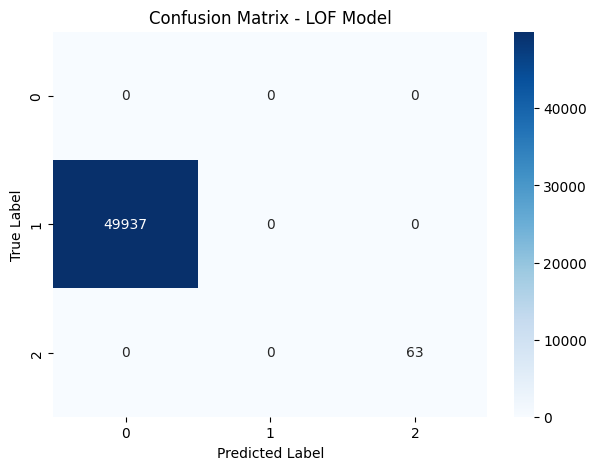

In [74]:
plt.figure(figsize=(7, 5))
sns.heatmap(lof_confusion_matrix, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix - LOF Model")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

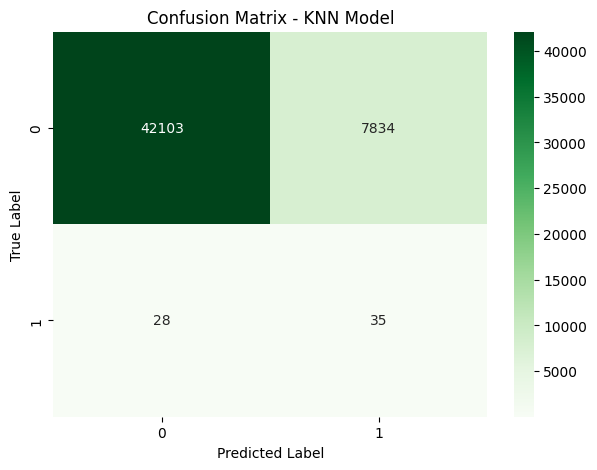

In [75]:
plt.figure(figsize=(7, 5))
sns.heatmap(knn_confusion_matrix, annot=True, fmt="d", cmap="Greens")
plt.title("Confusion Matrix - KNN Model")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

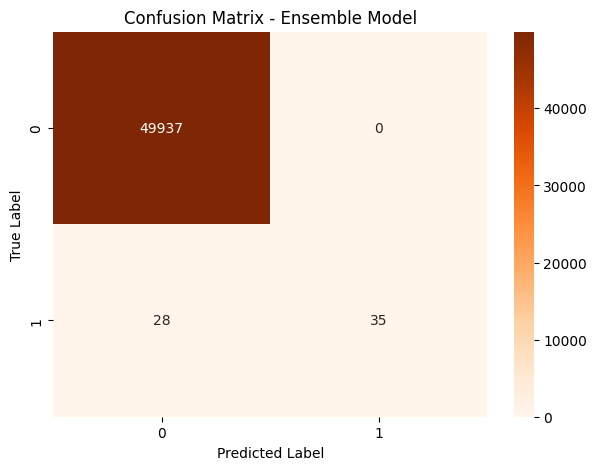

In [76]:
plt.figure(figsize=(7, 5))
sns.heatmap(ensemble_confusion_matrix, annot=True, fmt="d", cmap="Oranges")
plt.title("Confusion Matrix - Ensemble Model")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [78]:
lof_true_positives = lof_confusion_matrix[1, 1]
lof_false_negatives = lof_confusion_matrix[1, 0]
lof_false_positives = lof_confusion_matrix[0, 1]
lof_true_negatives = lof_confusion_matrix[0, 0]

In [79]:
knn_true_positives = knn_confusion_matrix[1, 1]
knn_false_negatives = knn_confusion_matrix[1, 0]
knn_false_positives = knn_confusion_matrix[0, 1]
knn_true_negatives = knn_confusion_matrix[0, 0]

In [80]:
ensemble_true_positives = ensemble_confusion_matrix[1, 1]
ensemble_false_negatives = ensemble_confusion_matrix[1, 0]
ensemble_false_positives = ensemble_confusion_matrix[0, 1]
ensemble_true_negatives = ensemble_confusion_matrix[0, 0]

In [81]:
print("LOF Confusion Matrix:")
print("True Positives:", lof_true_positives)
print("False Negatives:", lof_false_negatives)
print("False Positives:", lof_false_positives)
print("True Negatives:", lof_true_negatives)

LOF Confusion Matrix:
True Positives: 0
False Negatives: 49937
False Positives: 0
True Negatives: 0


In [82]:
print("\nKNN Confusion Matrix:")
print("True Positives:", knn_true_positives)
print("False Negatives:", knn_false_negatives)
print("False Positives:", knn_false_positives)
print("True Negatives:", knn_true_negatives)


KNN Confusion Matrix:
True Positives: 35
False Negatives: 28
False Positives: 7834
True Negatives: 42103


In [83]:
print("\nEnsemble Confusion Matrix:")
print("True Positives:", ensemble_true_positives)
print("False Negatives:", ensemble_false_negatives)
print("False Positives:", ensemble_false_positives)
print("True Negatives:", ensemble_true_negatives)


Ensemble Confusion Matrix:
True Positives: 35
False Negatives: 28
False Positives: 0
True Negatives: 49937


In [84]:
model_names = ['LOF', 'KNN', 'Ensemble']

In [85]:
tp_values = [lof_true_positives, knn_true_positives, ensemble_true_positives]
fn_values = [lof_false_negatives, knn_false_negatives, ensemble_false_negatives]
fp_values = [lof_false_positives, knn_false_positives, ensemble_false_positives]
tn_values = [lof_true_negatives, knn_true_negatives, ensemble_true_negatives]

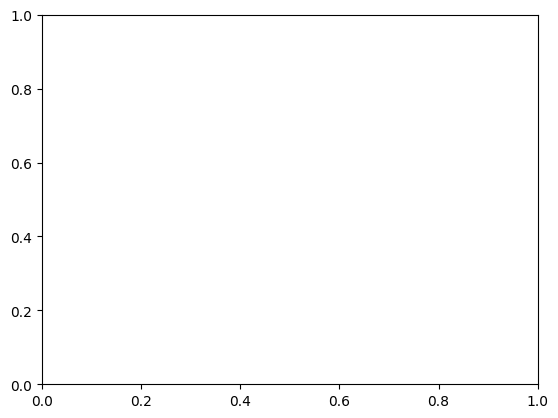

In [87]:
fig, ax = plt.subplots()
bar_width = 0.2
bar_positions = list(range(len(model_names)))

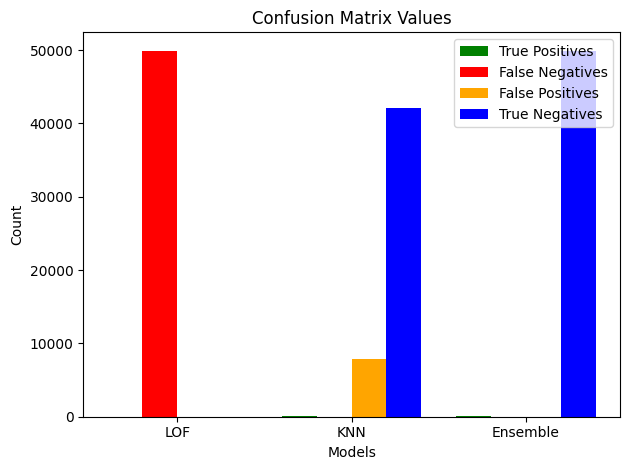

In [91]:
plt.bar(bar_positions, tp_values, color='green', width=bar_width, label='True Positives')
plt.bar([p + bar_width for p in bar_positions], fn_values, color='red', width=bar_width, label='False Negatives')
plt.bar([p + 2 * bar_width for p in bar_positions], fp_values, color='orange', width=bar_width, label='False Positives')
plt.bar([p + 3 * bar_width for p in bar_positions], tn_values, color='blue', width=bar_width, label='True Negatives')

plt.xlabel('Models')
plt.ylabel('Count')
plt.title('Confusion Matrix Values')
plt.xticks([p + 1.5 * bar_width for p in bar_positions], model_names)
plt.legend()
plt.tight_layout()
plt.show()

I will now go ahead to build this model upon a CNN TensorFlow

In [93]:
features = ['sc-status', 'cs-method', 'c-country', 'day_of_week', 'hour', 'minute', 'second', 'c-ip-int', 'browser_family', 'browser_version']
data = df[features]
target = df['ensemble_prediction']


In [94]:
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.2, random_state=42)

In [95]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [96]:
model = Sequential()
model.add(Dense(64, activation='relu', input_dim=X_train_scaled.shape[1]))
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [97]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [98]:
model.fit(X_train_scaled, y_train, epochs=10, batch_size=32, validation_data=(X_test_scaled, y_test))

Epoch 1/10
1250/1250 [==============================] - 6s 4ms/step - loss: 0.0269 - accuracy: 0.9959 - val_loss: 0.0129 - val_accuracy: 0.9994
Epoch 2/10
1250/1250 [==============================] - 2s 1ms/step - loss: 0.0073 - accuracy: 0.9993 - val_loss: 0.0042 - val_accuracy: 0.9994
Epoch 3/10
1250/1250 [==============================] - 2s 1ms/step - loss: 0.0041 - accuracy: 0.9993 - val_loss: 0.0039 - val_accuracy: 0.9995
Epoch 4/10
1250/1250 [==============================] - 2s 1ms/step - loss: 0.0033 - accuracy: 0.9994 - val_loss: 0.0035 - val_accuracy: 0.9995
Epoch 5/10
1250/1250 [==============================] - 2s 2ms/step - loss: 0.0030 - accuracy: 0.9995 - val_loss: 0.0044 - val_accuracy: 0.9993
Epoch 6/10
1250/1250 [==============================] - 2s 2ms/step - loss: 0.0027 - accuracy: 0.9995 - val_loss: 0.0036 - val_accuracy: 0.9995
Epoch 7/10
1250/1250 [==============================] - 2s 1ms/step - loss: 0.0025 - accuracy: 0.9995 - val_loss: 0.0032 - val_accuracy:

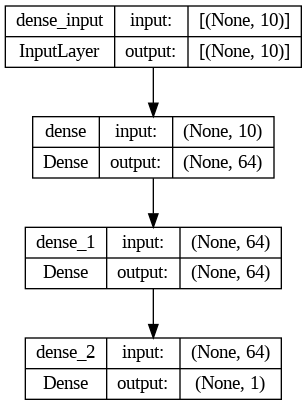

In [99]:
plot_model(model, to_file='neural_network.png', show_shapes=True)

In [100]:
loss, accuracy = model.evaluate(X_test_scaled, y_test)
print("Accuracy:", accuracy)

313/313 [==============================] - 1s 2ms/step - loss: 0.0034 - accuracy: 0.9996
Accuracy: 0.9995999932289124


In [102]:
y_pred_probs = model.predict(X_test_scaled)

313/313 [==============================] - 1s 1ms/step


In [103]:
y_pred = (y_pred_probs > 0.5).astype(int)

In [104]:
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
specificity = confusion_matrix(y_test, y_pred)[0, 0] / (confusion_matrix(y_test, y_pred)[0, 0] + confusion_matrix(y_test, y_pred)[0, 1])

In [105]:
auc_roc = roc_auc_score(y_test, y_pred_probs)

In [106]:
print("Precision:", precision)
print("Recall:", recall)
print("F1-Score:", f1)
print("Specificity:", specificity)
print("AUC-ROC:", auc_roc)

Precision: 1.0
Recall: 0.3333333333333333
F1-Score: 0.5
Specificity: 1.0
AUC-ROC: 0.9042091921819758


In [109]:
conf_matrix = confusion_matrix(y_test, y_pred)

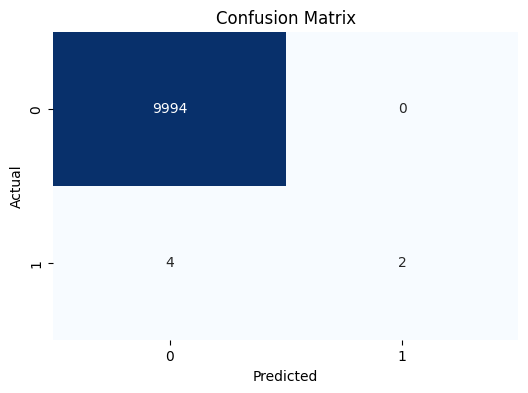

In [112]:
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [108]:
loss = model.evaluate(X_test_scaled, y_test)[0]
print("Loss:", loss)

313/313 [==============================] - 0s 1ms/step - loss: 0.0034 - accuracy: 0.9996
Loss: 0.0033544662874192


In [115]:
with open('/content/drive/MyDrive/model.pickle', 'wb') as f:
  pickle.dump(model, f)

print("Model saved as a pickle file.")

Model saved as a pickle file.


In [116]:
model = pickle.load(open("/content/drive/MyDrive/model.pickle", "rb"))

In [117]:
app = Flask(__name__)

In [118]:
@app.route("/", methods=["POST"])
def bot_detection():
    # Get the user attributes from the request
    user_attributes = request.get_json()

    # Convert the user attributes into a feature vector (assuming you have a function for this)
    feature_vector = features(user_attributes)

    # Make a prediction using the machine learning model
    prediction = model.predict([feature_vector])

    if prediction == 1:
        # Implement additional security measures (e.g., recommend captcha)
        recommendation = "Please complete the captcha."
        return {"recommendation": recommendation, "captcha_image_url": "/captcha"}
    else:
        # Allow access to the user
        return {"message": "Access granted."}

In [120]:
def generate_captcha():
    # Define the captcha dimensions
    width, height = 200, 80

    # Create a blank image
    image = Image.new("RGB", (width, height), (255, 255, 255))
    draw = ImageDraw.Draw(image)

    # Define the font properties
    font_size = 40
    font = ImageFont.truetype("arial.ttf", font_size)

    # Generate a random captcha text
    captcha_text = ''.join(random.choices(string.ascii_uppercase + string.digits, k=4))

    # Calculate the position to center the text
    text_width, text_height = draw.textsize(captcha_text, font=font)
    x = (width - text_width) / 2
    y = (height - text_height) / 2

    # Draw the captcha text on the image
    draw.text((x, y), captcha_text, font=font, fill=(0, 0, 0))

    # Add some random noise dots to the image
    for _ in range(300):
        draw.point((random.randint(0, width), random.randint(0, height)), fill=(0, 0, 0))

    # Save the captcha image
    image.save("captcha.png")

    # Return the captcha image object
    return image

In [121]:
@app.route("/captcha", methods=["GET"])
def get_captcha():
    # Generate and return a simple captcha image (assuming you have a function for this)
    captcha_image = generate_captcha()

    # In a real-world scenario, you would store the correct captcha answer in a database or session
    correct_captcha_answer = "ABCD"

    return captcha_image